# Enunciado + split expanding windows

In [39]:
import os
import tensorflow as tf

# Evita la asignación completa de memoria GPU al inicio
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

# Listar dispositivos GPU disponibles
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Establecer crecimiento dinámico de la memoria GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) configurada(s) correctamente con crecimiento dinámico.")
    except RuntimeError as e:
        print(f"Error al configurar la GPU: {e}")
else:
    print("No se detectó ninguna GPU disponible.")

# Activar compilación JIT (XLA) para optimización adicional
tf.config.optimizer.set_jit(True)


1 GPU(s) configurada(s) correctamente con crecimiento dinámico.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

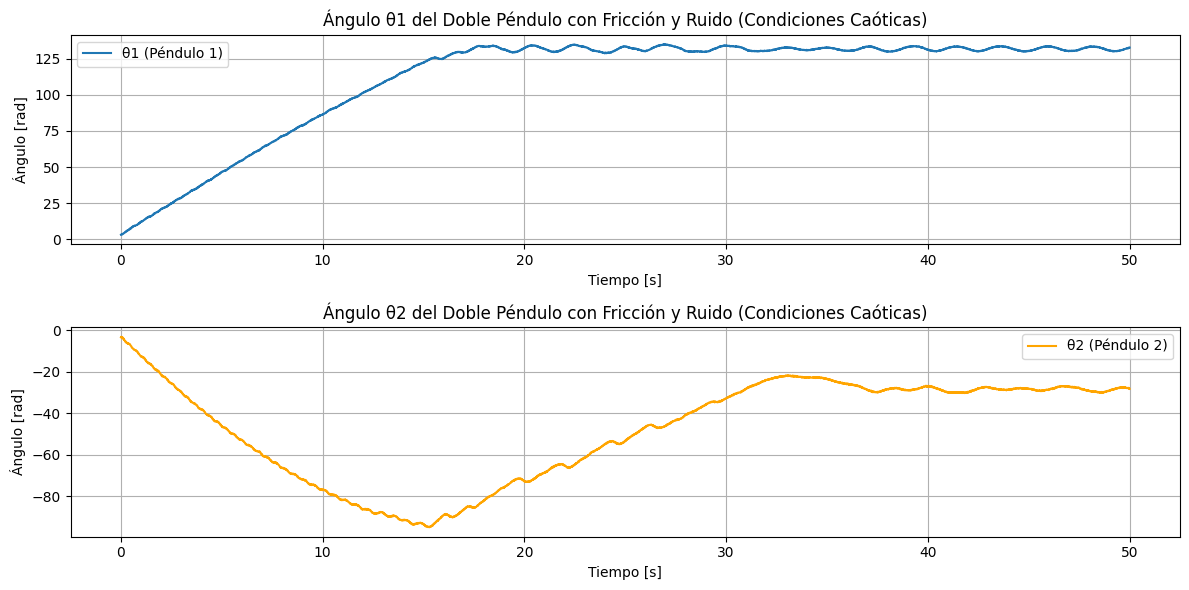

In [41]:
# Parámetros del doble péndulo
g = 9.81  
L1, L2 = 1.0, 1.0  # Longitudes de los péndulos
m1, m2 = 1.0, 1.0  # Masas
b1, b2 = 0.05, 0.05  # Fricción en las juntas
sigma = 0.1  # Ruido blanco gaussiano

# Condiciones iniciales caóticas
theta1_0, theta2_0 = np.radians(179), np.radians(-179)
omega1_0, omega2_0 = 5.0, -5.0
y0 = [theta1_0, omega1_0, theta2_0, omega2_0]

t_span = (0, 50)  
t_eval = np.linspace(t_span[0], t_span[1], 5000)  

# Ecuaciones del doble péndulo con fricción y ruido
def double_pendulum(t, y):
    theta1, omega1, theta2, omega2 = y

    noise1 = np.random.normal(0, sigma)
    noise2 = np.random.normal(0, sigma)

    delta_theta = theta2 - theta1

    M11 = (m1 + m2) * L1
    M12 = m2 * L2 * np.cos(delta_theta)
    M21 = L1 * np.cos(delta_theta)
    M22 = L2

    det = M11 * M22 - M12 * M21  # Determinante

    f1 = -m2 * L2 * omega2**2 * np.sin(delta_theta) - (m1 + m2) * g * np.sin(theta1) - b1 * omega1 + noise1
    f2 = L1 * omega1**2 * np.sin(delta_theta) - g * np.sin(theta2) - b2 * omega2 + noise2

    domega1_dt = (M22 * f1 - M12 * f2) / det
    domega2_dt = (-M21 * f1 + M11 * f2) / det

    return [omega1, domega1_dt, omega2, domega2_dt]

# Resolver ecuación diferencial
solution = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval)

# Extraer datos con ruido adicional
theta1_data = solution.y[0] + np.random.normal(0, sigma, size=len(t_eval))
theta2_data = solution.y[2] + np.random.normal(0, sigma, size=len(t_eval))

# Graficar theta1_data y theta2_data
plt.figure(figsize=(12, 6))

# Graficar theta1
plt.subplot(2, 1, 1)
plt.plot(t_eval, theta1_data, label="θ1 (Péndulo 1)")
plt.title("Ángulo θ1 del Doble Péndulo con Fricción y Ruido (Condiciones Caóticas)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Ángulo [rad]")
plt.grid(True)
plt.legend()

# Graficar theta2
plt.subplot(2, 1, 2)
plt.plot(t_eval, theta2_data, label="θ2 (Péndulo 2)", color="orange")
plt.title("Ángulo θ2 del Doble Péndulo con Fricción y Ruido (Condiciones Caóticas)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Ángulo [rad]")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
# ============================================================
# 2) Construir dataset con ventanas deslizantes MULTIVARIABLE
# ============================================================
window_size = 100
X, Y = [], []  # Cada muestra: (window_size, 2); target: [θ1(t+1), θ2(t+1)]
for i in range(len(t_eval) - window_size):
    window_theta1 = theta1_data[i:i+window_size]
    window_theta2 = theta2_data[i:i+window_size]
    window_input = np.column_stack([window_theta1, window_theta2])
    target = [theta1_data[i+window_size], theta2_data[i+window_size]]
    X.append(window_input)
    Y.append(target)
X = np.array(X)  # Shape: (num_samples, window_size, 2)
Y = np.array(Y)  # Shape: (num_samples, 2)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (4900, 100, 2)
Y shape: (4900, 2)


In [43]:
# ============================================================
# 3) División time-based split: Train, Val, Test
# ============================================================
train_size = int(len(X) * 0.70)
val_size   = int(len(X) * 0.15)  # ~15% para validación
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size + val_size], Y[train_size:train_size + val_size]
X_test, Y_test = X[train_size + val_size:], Y[train_size + val_size:]
print("Shapes:")
print("  X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("  X_val:  ", X_val.shape,   "Y_val:  ", Y_val.shape)
print("  X_test: ", X_test.shape,  "Y_test: ", Y_test.shape)

Shapes:
  X_train: (3430, 100, 2) Y_train: (3430, 2)
  X_val:   (735, 100, 2) Y_val:   (735, 2)
  X_test:  (735, 100, 2) Y_test:  (735, 2)


In [44]:
# ============================================================
# 4) Escalado MinMax en 2 canales
# ============================================================
# Escalar X: aplanamos a 2D, ajustamos con el train y luego transformamos
scaler_x = MinMaxScaler(feature_range=(-1,1))
X_train_2d = X_train.reshape(-1, 2)
scaler_x.fit(X_train_2d)
X_train = scaler_x.transform(X_train_2d).reshape(X_train.shape)
X_val = scaler_x.transform(X_val.reshape(-1,2)).reshape(X_val.shape)
X_test = scaler_x.transform(X_test.reshape(-1,2)).reshape(X_test.shape)

# Escalar Y
scaler_y = MinMaxScaler(feature_range=(-1,1))
scaler_y.fit(Y_train)
Y_train = scaler_y.transform(Y_train)
Y_val = scaler_y.transform(Y_val)
Y_test = scaler_y.transform(Y_test)
print("X_train shape:", X_train.shape, "Y_train shape:", Y_train.shape)

X_train shape: (3430, 100, 2) Y_train shape: (3430, 2)


## 1 capa unit=50

In [45]:
n_splits = 5
from sklearn.model_selection import TimeSeriesSplit
# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(50, input_shape=(window_size, 2), return_sequences=False),
        # LSTM(50, return_sequences=False),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1





Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.6664 - r2_score: -322.4315 - val_loss: 0.1646 - val_r2_score: -2.9207
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5679 - r2_score: -270.9922 - val_loss: 0.1531 - val_r2_score: -2.6447
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4820 - r2_score: -228.4222 - val_loss: 0.1414 - val_r2_score: -2.3663
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3971 - r2_score: -187.2097 - val_loss: 0.1295 - val_r2_score: -2.0813
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3108 - r2_score: -146.1062 - val_loss: 0.1171 - val_r2_score: -1.7852
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2218 - r2_score: -104.6207 - val_loss: 0.1041 - val_r2_score: -1.4764
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1321 - r2_score: -63.6120 - val_loss: 0.0912 - val_r2_score: -1.1689
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0537 - r2_score: -27.4963 -

Resultados CV (Expanding Window):
  Fold 1: Loss=0.0595, R2=-0.4265
  Fold 2: Loss=0.0123, R2=-0.1309
  Fold 3: Loss=0.0182, R2=-5.5264
  Fold 4: Loss=0.0056, R2=-4.7432
  Fold 5: Loss=0.0004, R2=0.8496

Promedio final en CV:
  Mean Loss = 0.0192
  Mean R2   = -1.9955

Mejor fold (Expanding Window) fue el 5 con R2=0.8496


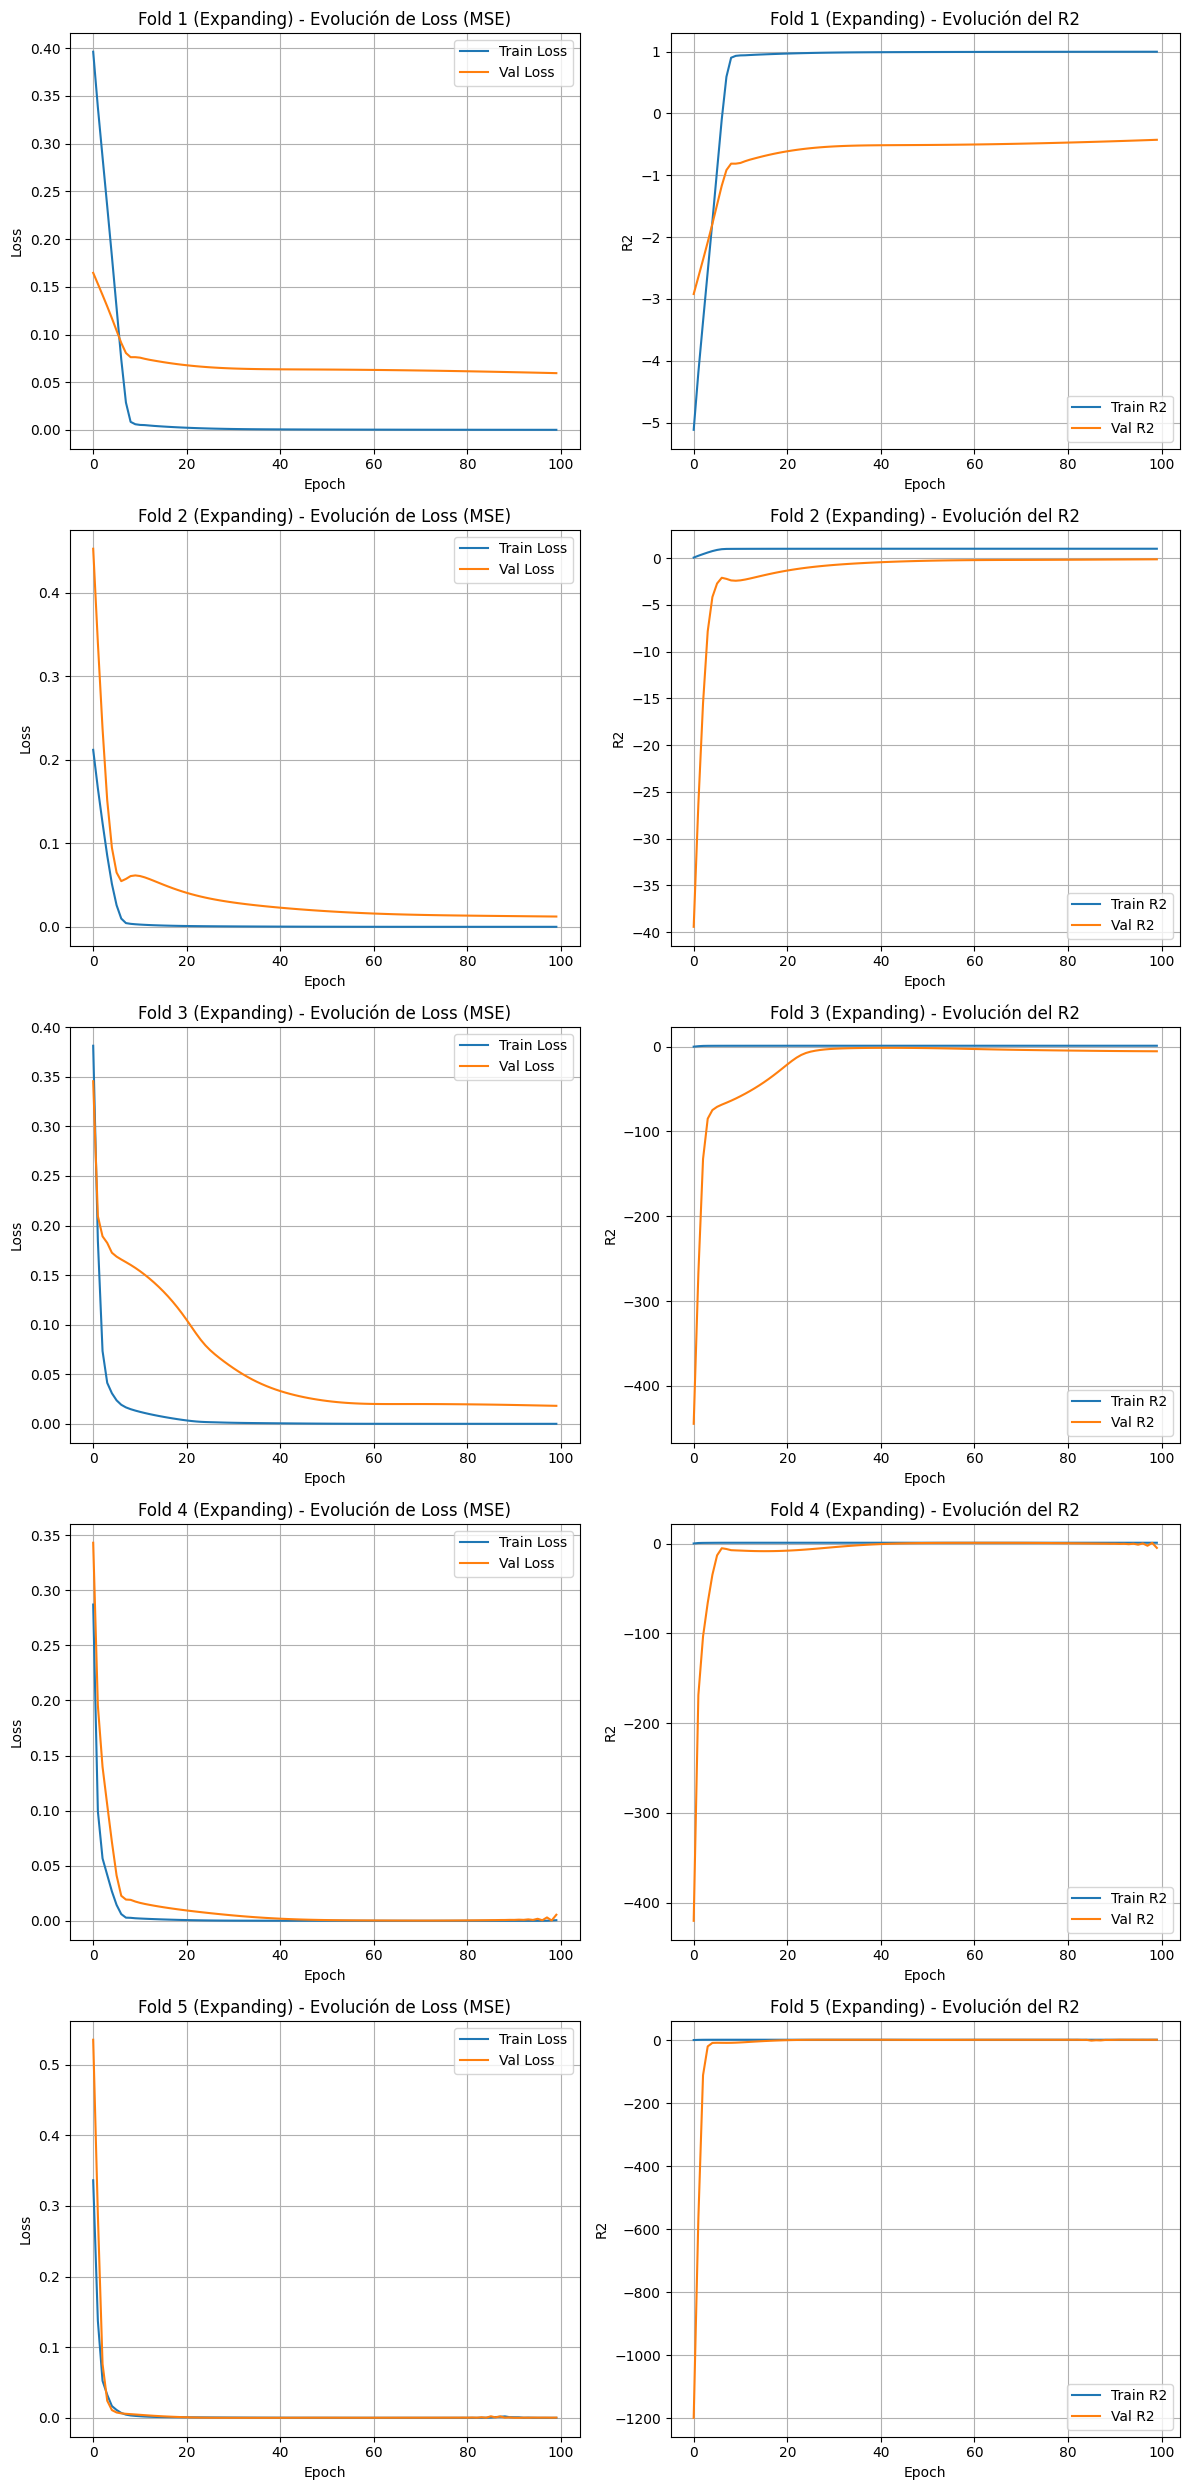

In [46]:
# --- After your training loop ---
fold_losses = [m['loss'] for m in fold_metrics_expanding]
fold_r2s   = [m['r2']   for m in fold_metrics_expanding]

mean_loss = np.mean(fold_losses)
mean_r2   = np.mean(fold_r2s)

print(f"Resultados CV (Expanding Window):")
for metrics in fold_metrics_expanding:
    print(f"  Fold {metrics['fold']}: Loss={metrics['loss']:.4f}, R2={metrics['r2']:.4f}")

print(f"\nPromedio final en CV:")
print(f"  Mean Loss = {mean_loss:.4f}")
print(f"  Mean R2   = {mean_r2:.4f}")

print(f"\nMejor fold (Expanding Window) fue el {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización de los cinco folds
fig, axes = plt.subplots(n_splits, 2, figsize=(12, 5 * n_splits))

for i in range(n_splits):
    history = fold_histories_expanding[i]
    ax1, ax2 = axes[i]

    ax1.plot(history['loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title(f'Fold {i + 1} (Expanding) - Evolución de Loss (MSE)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(history['r2_score'], label='Train R2')
    ax2.plot(history['val_r2_score'], label='Val R2')
    ax2.set_title(f'Fold {i + 1} (Expanding) - Evolución del R2')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('R2')
    ax2.grid(True)
    ax2.legend()

plt.tight_layout()
plt.show()

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

In [73]:
# --- Entrenar el modelo final con todo train + val ---
X_train_val = np.concatenate([X_train, X_val], axis=0)
Y_train_val = np.concatenate([Y_train, Y_val], axis=0)

# Definir el modelo final con la misma configuración (por ejemplo, LSTM(50) y Dense(2))
model_final = Sequential([
    LSTM(50, input_shape=(window_size, 2), return_sequences=False),
    Dense(2)
])

model_final.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

# Entrenar el modelo final (puedes usar un pequeño validation_split para monitorear el proceso)
history_final = model_final.fit(
    X_train_val, Y_train_val,
    epochs=100,
    batch_size=32,
    # validation_split=0.1,
    shuffle=False,
    verbose=1
)

# --- Evaluar en el conjunto de test ---
Y_pred_test = model_final.predict(X_test)
Y_pred_test_inv = scaler_y.inverse_transform(Y_pred_test)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Definir el eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# --- Graficar la predicción vs. datos reales ---
plt.figure(figsize=(12, 6))

# Gráfica para θ1
plt.subplot(2, 1, 1)
plt.plot(t_test, Y_test_inv[:, 0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_inv[:, 0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Modelo Final)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# Gráfica para θ2
plt.subplot(2, 1, 2)
plt.plot(t_test, Y_test_inv[:, 1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_inv[:, 1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Modelo Final)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Calcular e imprimir métricas en Test ---
mse_final = mean_squared_error(Y_test_inv, Y_pred_test_inv)
mae_final = mean_absolute_error(Y_test_inv, Y_pred_test_inv)
r2_final  = r2_score(Y_test_inv, Y_pred_test_inv)

print("Métricas Globales en Test (Modelo Final con Train+Val):")
print(f"MSE: {mse_final:.4f}")
print(f"MAE: {mae_final:.4f}")
print(f"R2:  {r2_final:.4f}")


Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2751 - r2_score: -27.7542
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1147 - r2_score: -13.0146
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0536 - r2_score: -7.4727
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0298 - r2_score: -4.7344
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0179 - r2_score: -2.5020
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0094 - r2_score: -0.7563
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052 - r2_score: 0.1182
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - r2_score: 0.4373
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - r2_score: 0.4943
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0025 - r2_score: 0.5041
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - r2_score: 0.5242
Epoch 12/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 

KeyboardInterrupt: 

---

## 1 capa unit=100


In [48]:
n_splits = 5
from sklearn.model_selection import TimeSeriesSplit
# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(100, input_shape=(window_size, 2), return_sequences=False),
        # LSTM(50, return_sequences=False),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1





Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.4116 - r2_score: -187.4597 - val_loss: 0.1012 - val_r2_score: -1.4034
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2964 - r2_score: -132.1850 - val_loss: 0.0869 - val_r2_score: -1.0637
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1934 - r2_score: -85.2563 - val_loss: 0.0716 - val_r2_score: -0.6998
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0850 - r2_score: -36.9349 - val_loss: 0.0560 - val_r2_score: -0.3283
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0115 - r2_score: -3.6144 - val_loss: 0.0476 - val_r2_score: -0.1292
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - r2_score: -0.8083 - val_loss: 0.0469 - val_r2_score: -0.1119
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - r2_score: -0.4824 - val_loss: 0.0440 - val_r2_score: -0.0440
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - r2_score: -0.0150 - val_los

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1637e-04 - r2_score: 0.9151 - val_loss: 0.0268 - val_r2_score: 0.3631
Epoch 32/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2052e-04 - r2_score: 0.9100 - val_loss: 0.0266 - val_r2_score: 0.3669
Epoch 33/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1258e-04 - r2_score: 0.9190 - val_loss: 0.0264 - val_r2_score: 0.3716
Epoch 34/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1732e-04 - r2_score: 0.9129 - val_loss: 0.0263 - val_r2_score: 0.3755
Epoch 35/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0970e-04 - r2_score: 0.9218 - val_loss: 0.0261 - val_r2_score: 0.3798
Epoch 36/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1380e-04 - r2_score: 0.9165 - val_loss: 0.0259 - val_r2_score: 0.3836
Epoch 37/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0728e-04 - r2_score: 0.9242 - val_loss: 0.0257 - val_r2_score: 0.3878
Epoch 38/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1042e-04 - r2_score

Resultados CV (Expanding Window):
  Fold 1: Loss=0.0190, R2=0.5472
  Fold 2: Loss=0.0074, R2=0.1450
  Fold 3: Loss=0.0056, R2=0.6802
  Fold 4: Loss=0.0012, R2=0.8328
  Fold 5: Loss=0.0002, R2=0.8582

Promedio final en CV:
  Mean Loss = 0.0067
  Mean R2   = 0.6127

Mejor fold (Expanding Window) fue el 5 con R2=0.8582


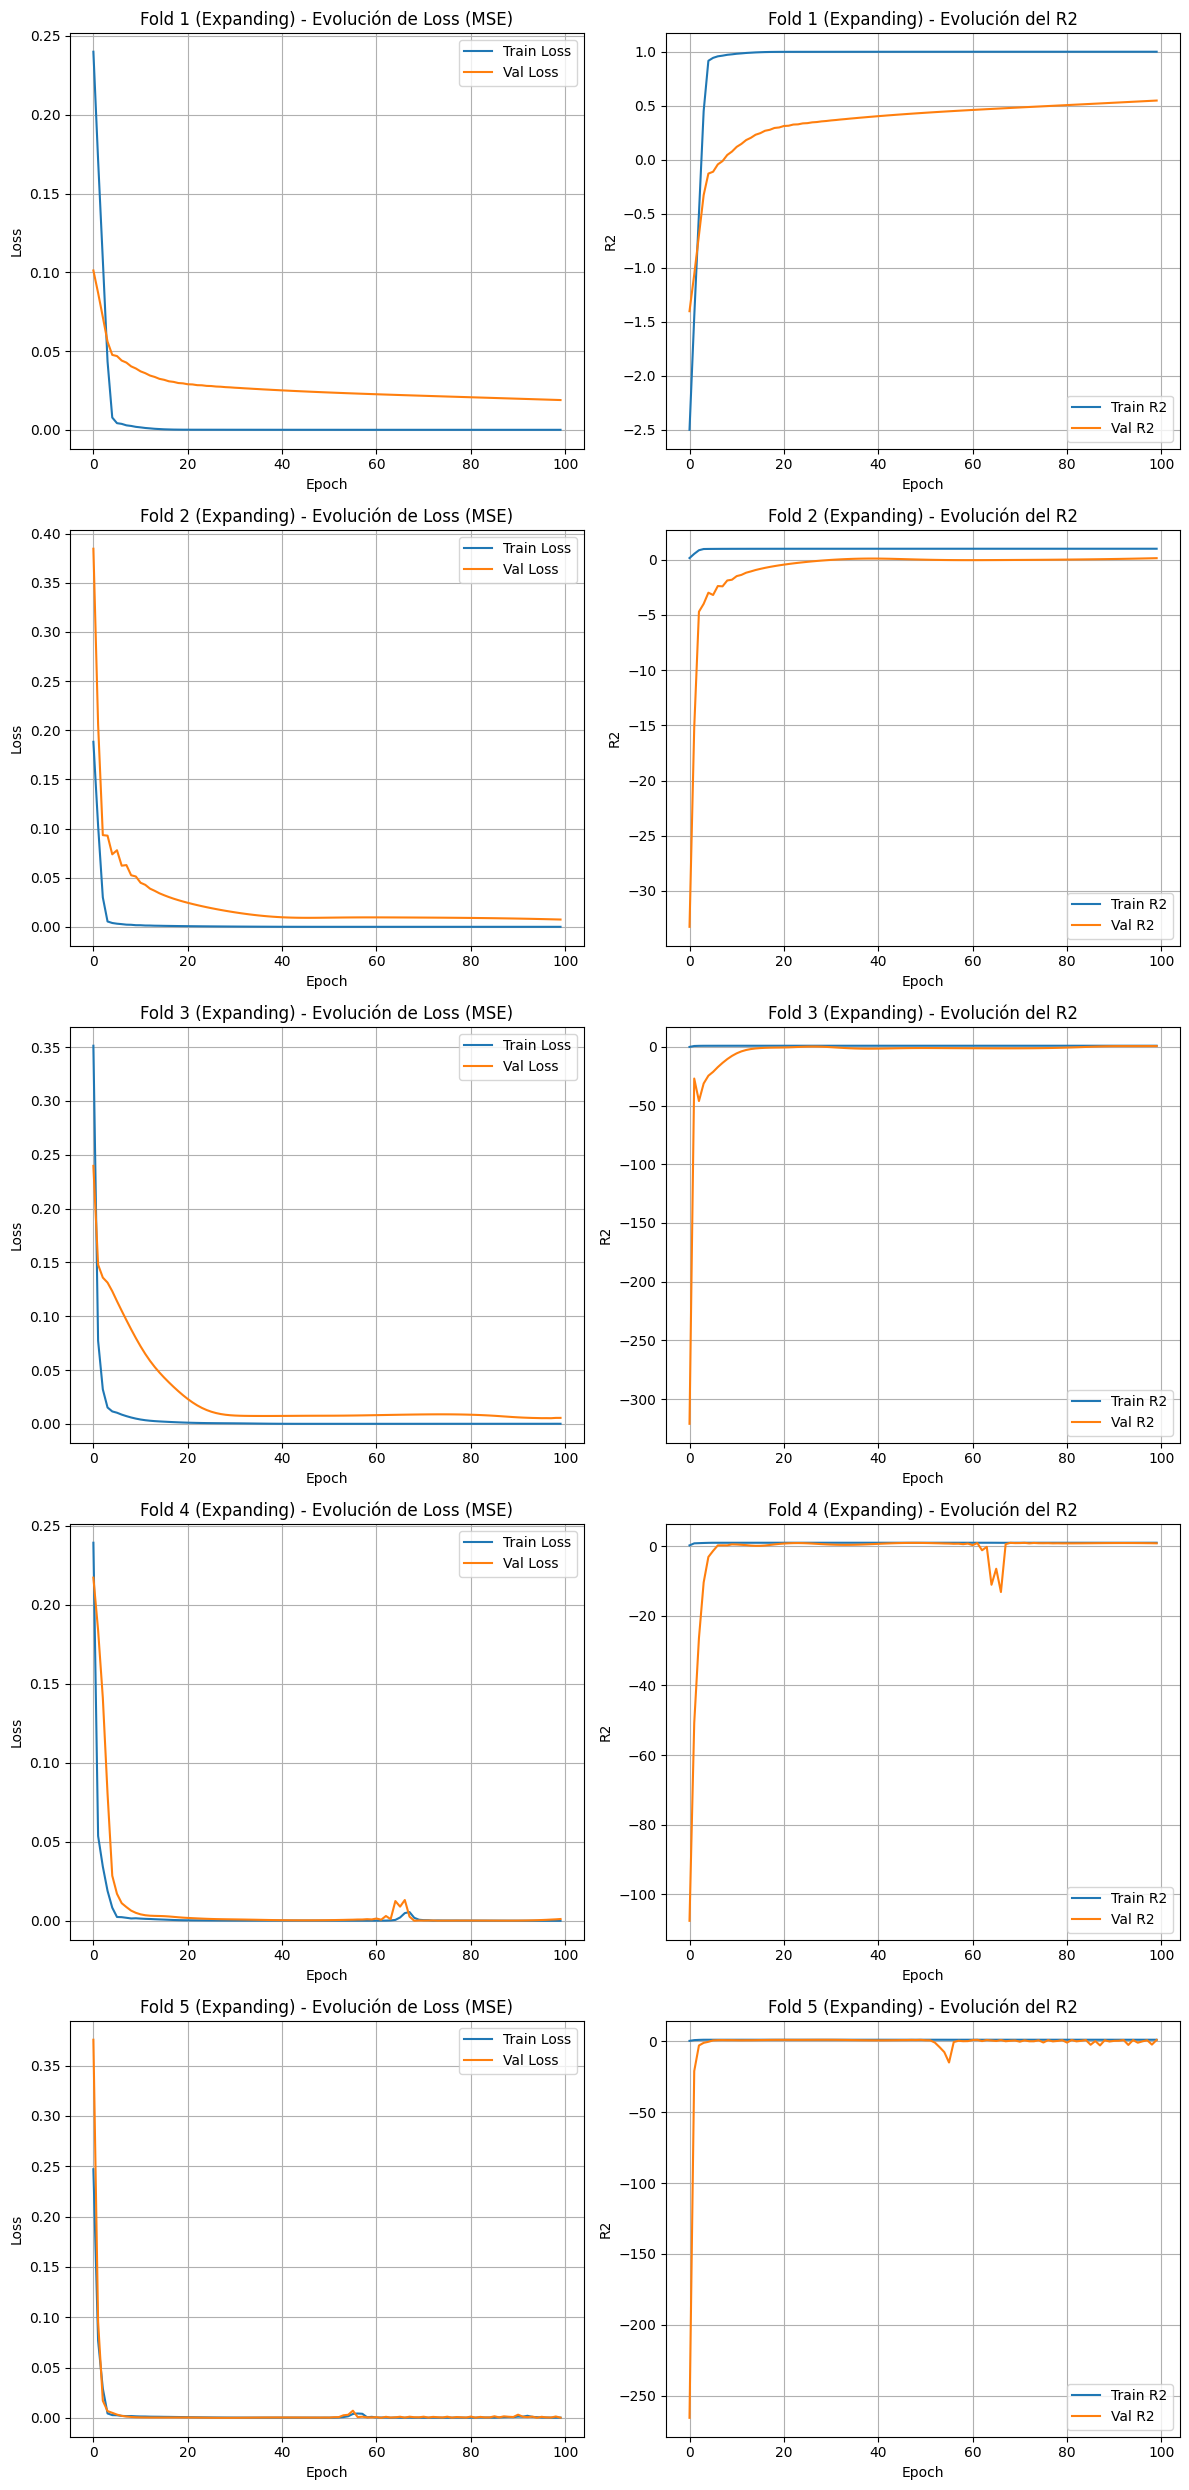

In [49]:
# --- After your training loop ---
fold_losses = [m['loss'] for m in fold_metrics_expanding]
fold_r2s   = [m['r2']   for m in fold_metrics_expanding]

mean_loss = np.mean(fold_losses)
mean_r2   = np.mean(fold_r2s)

print(f"Resultados CV (Expanding Window):")
for metrics in fold_metrics_expanding:
    print(f"  Fold {metrics['fold']}: Loss={metrics['loss']:.4f}, R2={metrics['r2']:.4f}")

print(f"\nPromedio final en CV:")
print(f"  Mean Loss = {mean_loss:.4f}")
print(f"  Mean R2   = {mean_r2:.4f}")

print(f"\nMejor fold (Expanding Window) fue el {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización de los cinco folds
fig, axes = plt.subplots(n_splits, 2, figsize=(12, 5 * n_splits))

for i in range(n_splits):
    history = fold_histories_expanding[i]
    ax1, ax2 = axes[i]

    ax1.plot(history['loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title(f'Fold {i + 1} (Expanding) - Evolución de Loss (MSE)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(history['r2_score'], label='Train R2')
    ax2.plot(history['val_r2_score'], label='Val R2')
    ax2.set_title(f'Fold {i + 1} (Expanding) - Evolución del R2')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('R2')
    ax2.grid(True)
    ax2.legend()

plt.tight_layout()
plt.show()

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1859 - r2_score: -27.6652 - val_loss: 0.0136 - val_r2_score: -29.8133
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0935 - r2_score: -6.1197 - val_loss: 9.1609e-04 - val_r2_score: -1.4666
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0148 - r2_score: -0.4042 - val_loss: 2.2697e-04 - val_r2_score: 0.4189
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - r2_score: -0.5700 - val_loss: 3.0234e-04 - val_r2_score: 0.2360
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - r2_score: 0.8266 - val_loss: 3.4281e-04 - val_r2_score: 0.1842
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.7711e-04 - r2_score: 0.9044 - val_loss: 3.8453e-04 - val_r2_score: 0.1278
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6539e-04 - r2_score: 0.9187 - val_loss: 4.4265e-04 - val_r2_score: 0.0304
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - 

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2928e-04 - r2_score: 0.9461 - val_loss: 8.0895e-04 - val_r2_score: -0.5811
Epoch 14/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4704e-04 - r2_score: 0.9405 - val_loss: 8.4258e-04 - val_r2_score: -0.6146
Epoch 15/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.6509e-04 - r2_score: 0.9405 - val_loss: 8.7870e-04 - val_r2_score: -0.6558
Epoch 16/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1879e-04 - r2_score: 0.9280 - val_loss: 9.1986e-04 - val_r2_score: -0.7129
Epoch 17/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4335e-04 - r2_score: 0.9246 - val_loss: 9.6651e-04 - val_r2_score: -0.7868
Epoch 18/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.8112e-04 - r2_score: 0.9193 - val_loss: 0.0010 - val_r2_score: -0.8710
Epoch 19/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2835e-04 - r2_score: 0.9083 - val_loss: 0.0011 - val_r2_score: -0.9632
Epoch 20/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms

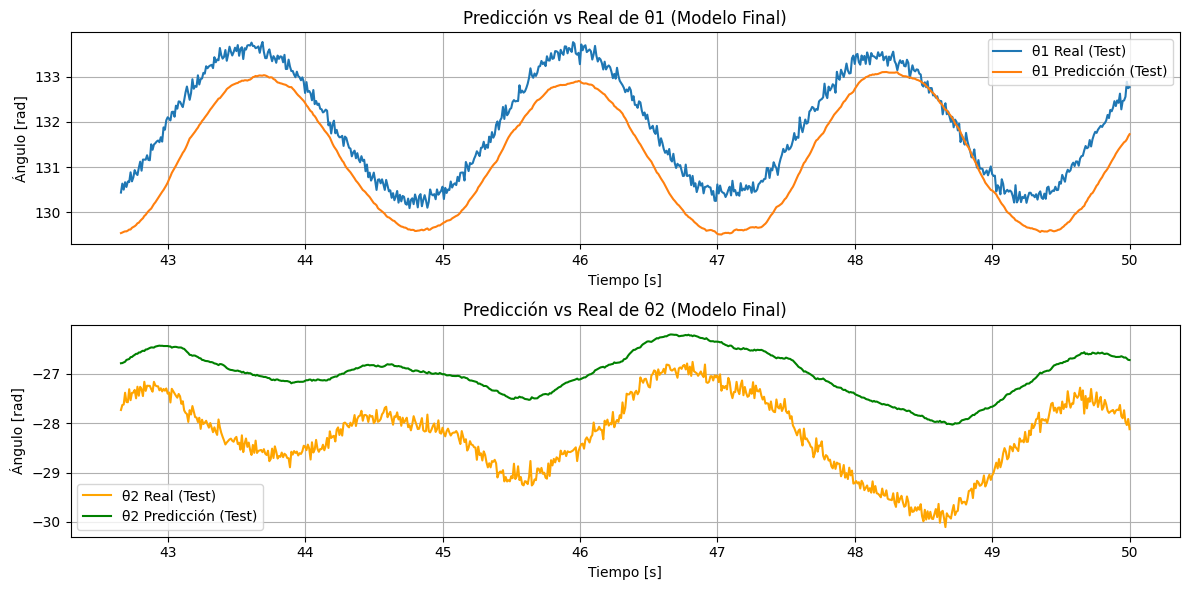

Métricas Globales en Test (Modelo Final con Train+Val):
MSE: 1.1305
MAE: 0.9750
R2:  -0.6238


In [50]:
# --- Entrenar el modelo final con todo train + val ---
X_train_val = np.concatenate([X_train, X_val], axis=0)
Y_train_val = np.concatenate([Y_train, Y_val], axis=0)

# Definir el modelo final con la misma configuración (por ejemplo, LSTM(50) y Dense(2))
model_final = Sequential([
    LSTM(100, input_shape=(window_size, 2), return_sequences=False),
    # LSTM(50, return_sequences=False),
    Dense(2)
])

model_final.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

# Entrenar el modelo final (puedes usar un pequeño validation_split para monitorear el proceso)
history_final = model_final.fit(
    X_train_val, Y_train_val,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)

# --- Evaluar en el conjunto de test ---
Y_pred_test = model_final.predict(X_test)
Y_pred_test_inv = scaler_y.inverse_transform(Y_pred_test)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Definir el eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# --- Graficar la predicción vs. datos reales ---
plt.figure(figsize=(12, 6))

# Gráfica para θ1
plt.subplot(2, 1, 1)
plt.plot(t_test, Y_test_inv[:, 0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_inv[:, 0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Modelo Final)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# Gráfica para θ2
plt.subplot(2, 1, 2)
plt.plot(t_test, Y_test_inv[:, 1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_inv[:, 1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Modelo Final)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Calcular e imprimir métricas en Test ---
mse_final = mean_squared_error(Y_test_inv, Y_pred_test_inv)
mae_final = mean_absolute_error(Y_test_inv, Y_pred_test_inv)
r2_final  = r2_score(Y_test_inv, Y_pred_test_inv)

print("Métricas Globales en Test (Modelo Final con Train+Val):")
print(f"MSE: {mse_final:.4f}")
print(f"MAE: {mae_final:.4f}")
print(f"R2:  {r2_final:.4f}")


---

## 2 capa unit=50

In [51]:
n_splits = 5
from sklearn.model_selection import TimeSeriesSplit
# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(50, input_shape=(window_size, 2), return_sequences=True),
        LSTM(50, return_sequences=False),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1





Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.5704 - r2_score: -296.8852 - val_loss: 0.1500 - val_r2_score: -2.5765
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4716 - r2_score: -240.2019 - val_loss: 0.1364 - val_r2_score: -2.2502
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3748 - r2_score: -189.4495 - val_loss: 0.1208 - val_r2_score: -1.8774
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2578 - r2_score: -130.9380 - val_loss: 0.1033 - val_r2_score: -1.4580
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1224 - r2_score: -62.7220 - val_loss: 0.0861 - val_r2_score: -1.0468
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0288 - r2_score: -11.4994 - val_loss: 0.0768 - val_r2_score: -0.8250
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0088 - r2_score: -2.0837 - val_loss: 0.0754 - val_r2_score: -0.7935
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0094 - r2_score: -3.3336 - val

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - r2_score: 0.2976 - val_loss: 0.0425 - val_r2_score: -1.2622
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - r2_score: 0.2578 - val_loss: 0.0389 - val_r2_score: -1.0758
Epoch 13/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0021 - r2_score: 0.2879 - val_loss: 0.0359 - val_r2_score: -0.9225
Epoch 14/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020 - r2_score: 0.2770 - val_loss: 0.0331 - val_r2_score: -0.7801
Epoch 15/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - r2_score: 0.3107 - val_loss: 0.0307 - val_r2_score: -0.6585
Epoch 16/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - r2_score: 0.3176 - val_loss: 0.0285 - val_r2_score: -0.5458
Epoch 17/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - r2_score: 0.3532 - val_loss: 0.0266 - val_r2_score: -0.4465
Epoch 18/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - r2_score: 0.3704 - val_loss: 0.02

Resultados CV (Expanding Window):
  Fold 1: Loss=0.0505, R2=-0.2050
  Fold 2: Loss=0.0103, R2=0.1828
  Fold 3: Loss=0.0081, R2=-0.8603
  Fold 4: Loss=0.0018, R2=-1.1061
  Fold 5: Loss=0.0002, R2=0.6821

Promedio final en CV:
  Mean Loss = 0.0142
  Mean R2   = -0.2613

Mejor fold (Expanding Window) fue el 5 con R2=0.6821


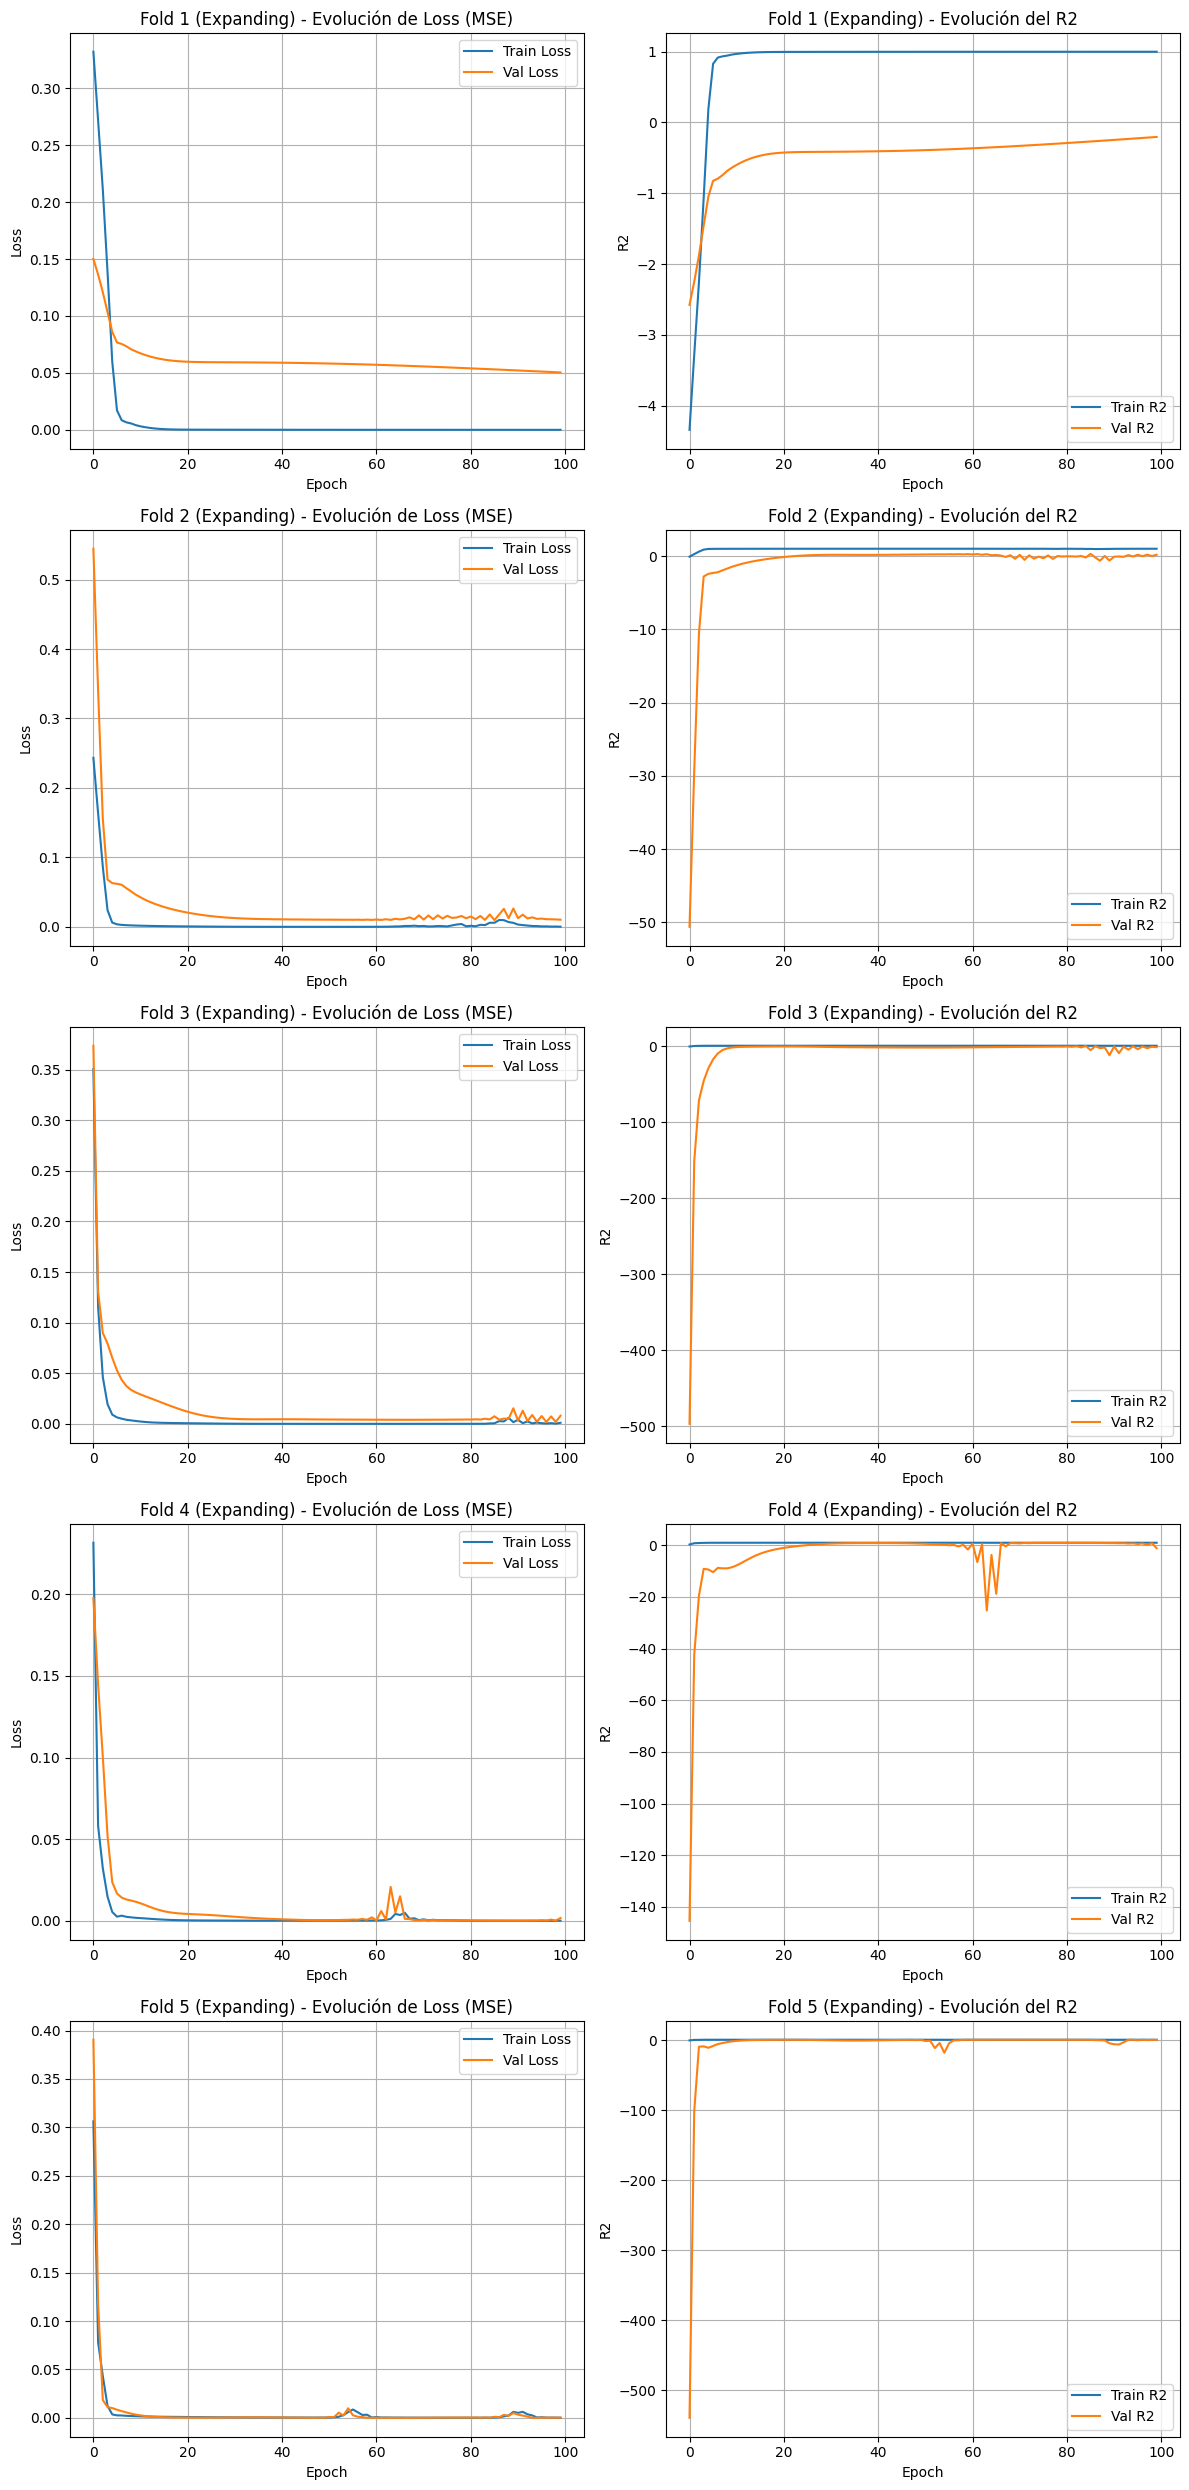

In [52]:
# --- After your training loop ---
fold_losses = [m['loss'] for m in fold_metrics_expanding]
fold_r2s   = [m['r2']   for m in fold_metrics_expanding]

mean_loss = np.mean(fold_losses)
mean_r2   = np.mean(fold_r2s)

print(f"Resultados CV (Expanding Window):")
for metrics in fold_metrics_expanding:
    print(f"  Fold {metrics['fold']}: Loss={metrics['loss']:.4f}, R2={metrics['r2']:.4f}")

print(f"\nPromedio final en CV:")
print(f"  Mean Loss = {mean_loss:.4f}")
print(f"  Mean R2   = {mean_r2:.4f}")

print(f"\nMejor fold (Expanding Window) fue el {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización de los cinco folds
fig, axes = plt.subplots(n_splits, 2, figsize=(12, 5 * n_splits))

for i in range(n_splits):
    history = fold_histories_expanding[i]
    ax1, ax2 = axes[i]

    ax1.plot(history['loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title(f'Fold {i + 1} (Expanding) - Evolución de Loss (MSE)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(history['r2_score'], label='Train R2')
    ax2.plot(history['val_r2_score'], label='Val R2')
    ax2.set_title(f'Fold {i + 1} (Expanding) - Evolución del R2')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('R2')
    ax2.grid(True)
    ax2.legend()

plt.tight_layout()
plt.show()

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2609 - r2_score: -40.4015 - val_loss: 0.0060 - val_r2_score: -10.9705
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1181 - r2_score: -14.4701 - val_loss: 0.0015 - val_r2_score: -1.7426
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0276 - r2_score: -6.2844 - val_loss: 5.9873e-04 - val_r2_score: -0.1241
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0082 - r2_score: -1.3359 - val_loss: 2.7314e-04 - val_r2_score: 0.4512
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0043 - r2_score: 0.1418 - val_loss: 1.5894e-04 - val_r2_score: 0.6624
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0039 - r2_score: 0.2819 - val_loss: 1.2244e-04 - val_r2_score: 0.7418
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0039 - r2_score: 0.1785 - val_loss: 1.1340e-04 - val_r2_score: 0.7635
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - r2_score: 0.8320 - val_loss: 0.0020 - val_r2_score: -2.5926
Epoch 41/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - r2_score: 0.8407 - val_loss: 0.0020 - val_r2_score: -2.6385
Epoch 42/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - r2_score: 0.8264 - val_loss: 0.0019 - val_r2_score: -2.4888
Epoch 43/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - r2_score: 0.8147 - val_loss: 0.0018 - val_r2_score: -2.2180
Epoch 44/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - r2_score: 0.8240 - val_loss: 0.0016 - val_r2_score: -1.9033
Epoch 45/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.9843e-04 - r2_score: 0.8532 - val_loss: 0.0015 - val_r2_score: -1.6013
Epoch 46/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3815e-04 - r2_score: 0.8907 - val_loss: 0.0013 - val_r2_score: -1.3520
Epoch 47/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6085e-04 - r2_sc

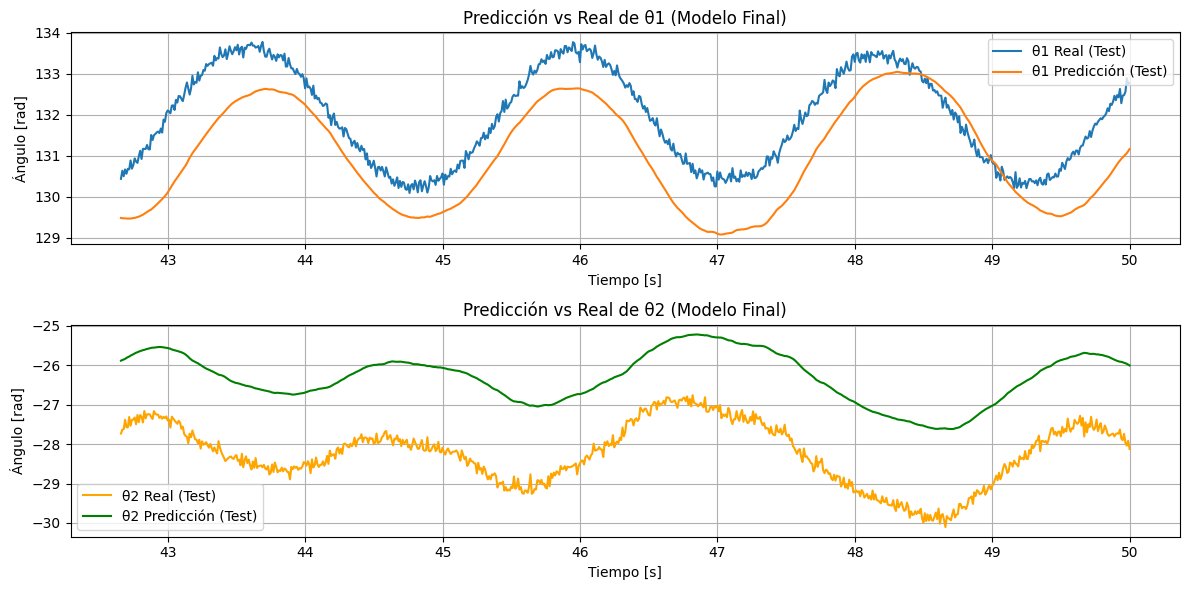

Métricas Globales en Test (Modelo Final con Train+Val):
MSE: 2.4605
MAE: 1.4505
R2:  -2.6078


In [53]:
# --- Entrenar el modelo final con todo train + val ---
X_train_val = np.concatenate([X_train, X_val], axis=0)
Y_train_val = np.concatenate([Y_train, Y_val], axis=0)

# Definir el modelo final con la misma configuración (por ejemplo, LSTM(50) y Dense(2))
model_final = Sequential([
    LSTM(50, input_shape=(window_size, 2), return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(2)
])

model_final.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

# Entrenar el modelo final (puedes usar un pequeño validation_split para monitorear el proceso)
history_final = model_final.fit(
    X_train_val, Y_train_val,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)

# --- Evaluar en el conjunto de test ---
Y_pred_test = model_final.predict(X_test)
Y_pred_test_inv = scaler_y.inverse_transform(Y_pred_test)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Definir el eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# --- Graficar la predicción vs. datos reales ---
plt.figure(figsize=(12, 6))

# Gráfica para θ1
plt.subplot(2, 1, 1)
plt.plot(t_test, Y_test_inv[:, 0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_inv[:, 0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Modelo Final)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# Gráfica para θ2
plt.subplot(2, 1, 2)
plt.plot(t_test, Y_test_inv[:, 1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_inv[:, 1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Modelo Final)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Calcular e imprimir métricas en Test ---
mse_final = mean_squared_error(Y_test_inv, Y_pred_test_inv)
mae_final = mean_absolute_error(Y_test_inv, Y_pred_test_inv)
r2_final  = r2_score(Y_test_inv, Y_pred_test_inv)

print("Métricas Globales en Test (Modelo Final con Train+Val):")
print(f"MSE: {mse_final:.4f}")
print(f"MAE: {mae_final:.4f}")
print(f"R2:  {r2_final:.4f}")


---

## 2 capa unit=100

In [75]:
n_splits = 5
from sklearn.model_selection import TimeSeriesSplit
# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(100, input_shape=(window_size, 2), return_sequences=True),
        # LSTM(50, return_sequences=True),
        LSTM(100, return_sequences=False),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1





Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.5529 - r2_score: -284.0587 - val_loss: 0.1386 - val_r2_score: -2.2970
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3359 - r2_score: -175.1860 - val_loss: 0.0989 - val_r2_score: -1.3495
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1179 - r2_score: -64.5517 - val_loss: 0.0608 - val_r2_score: -0.4420
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0151 - r2_score: -6.7610 - val_loss: 0.0561 - val_r2_score: -0.3320
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0085 - r2_score: -3.1023 - val_loss: 0.0503 - val_r2_score: -0.1923
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0048 - r2_score: -0.8027 - val_loss: 0.0457 - val_r2_score: -0.0855
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0027 - r2_score: -0.0219 - val_loss: 0.0418 - val_r2_score: 0.0079
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0015 - r2_score: 0.4735 - val_loss: 

Resultados CV (Expanding Window):
  Fold 1: Loss=0.0176, R2=0.5792
  Fold 2: Loss=0.0070, R2=0.0515
  Fold 3: Loss=0.0020, R2=0.8754
  Fold 4: Loss=0.0003, R2=0.7704
  Fold 5: Loss=0.0004, R2=0.5313

Promedio final en CV:
  Mean Loss = 0.0055
  Mean R2   = 0.5616

Mejor fold (Expanding Window) fue el 3 con R2=0.8754


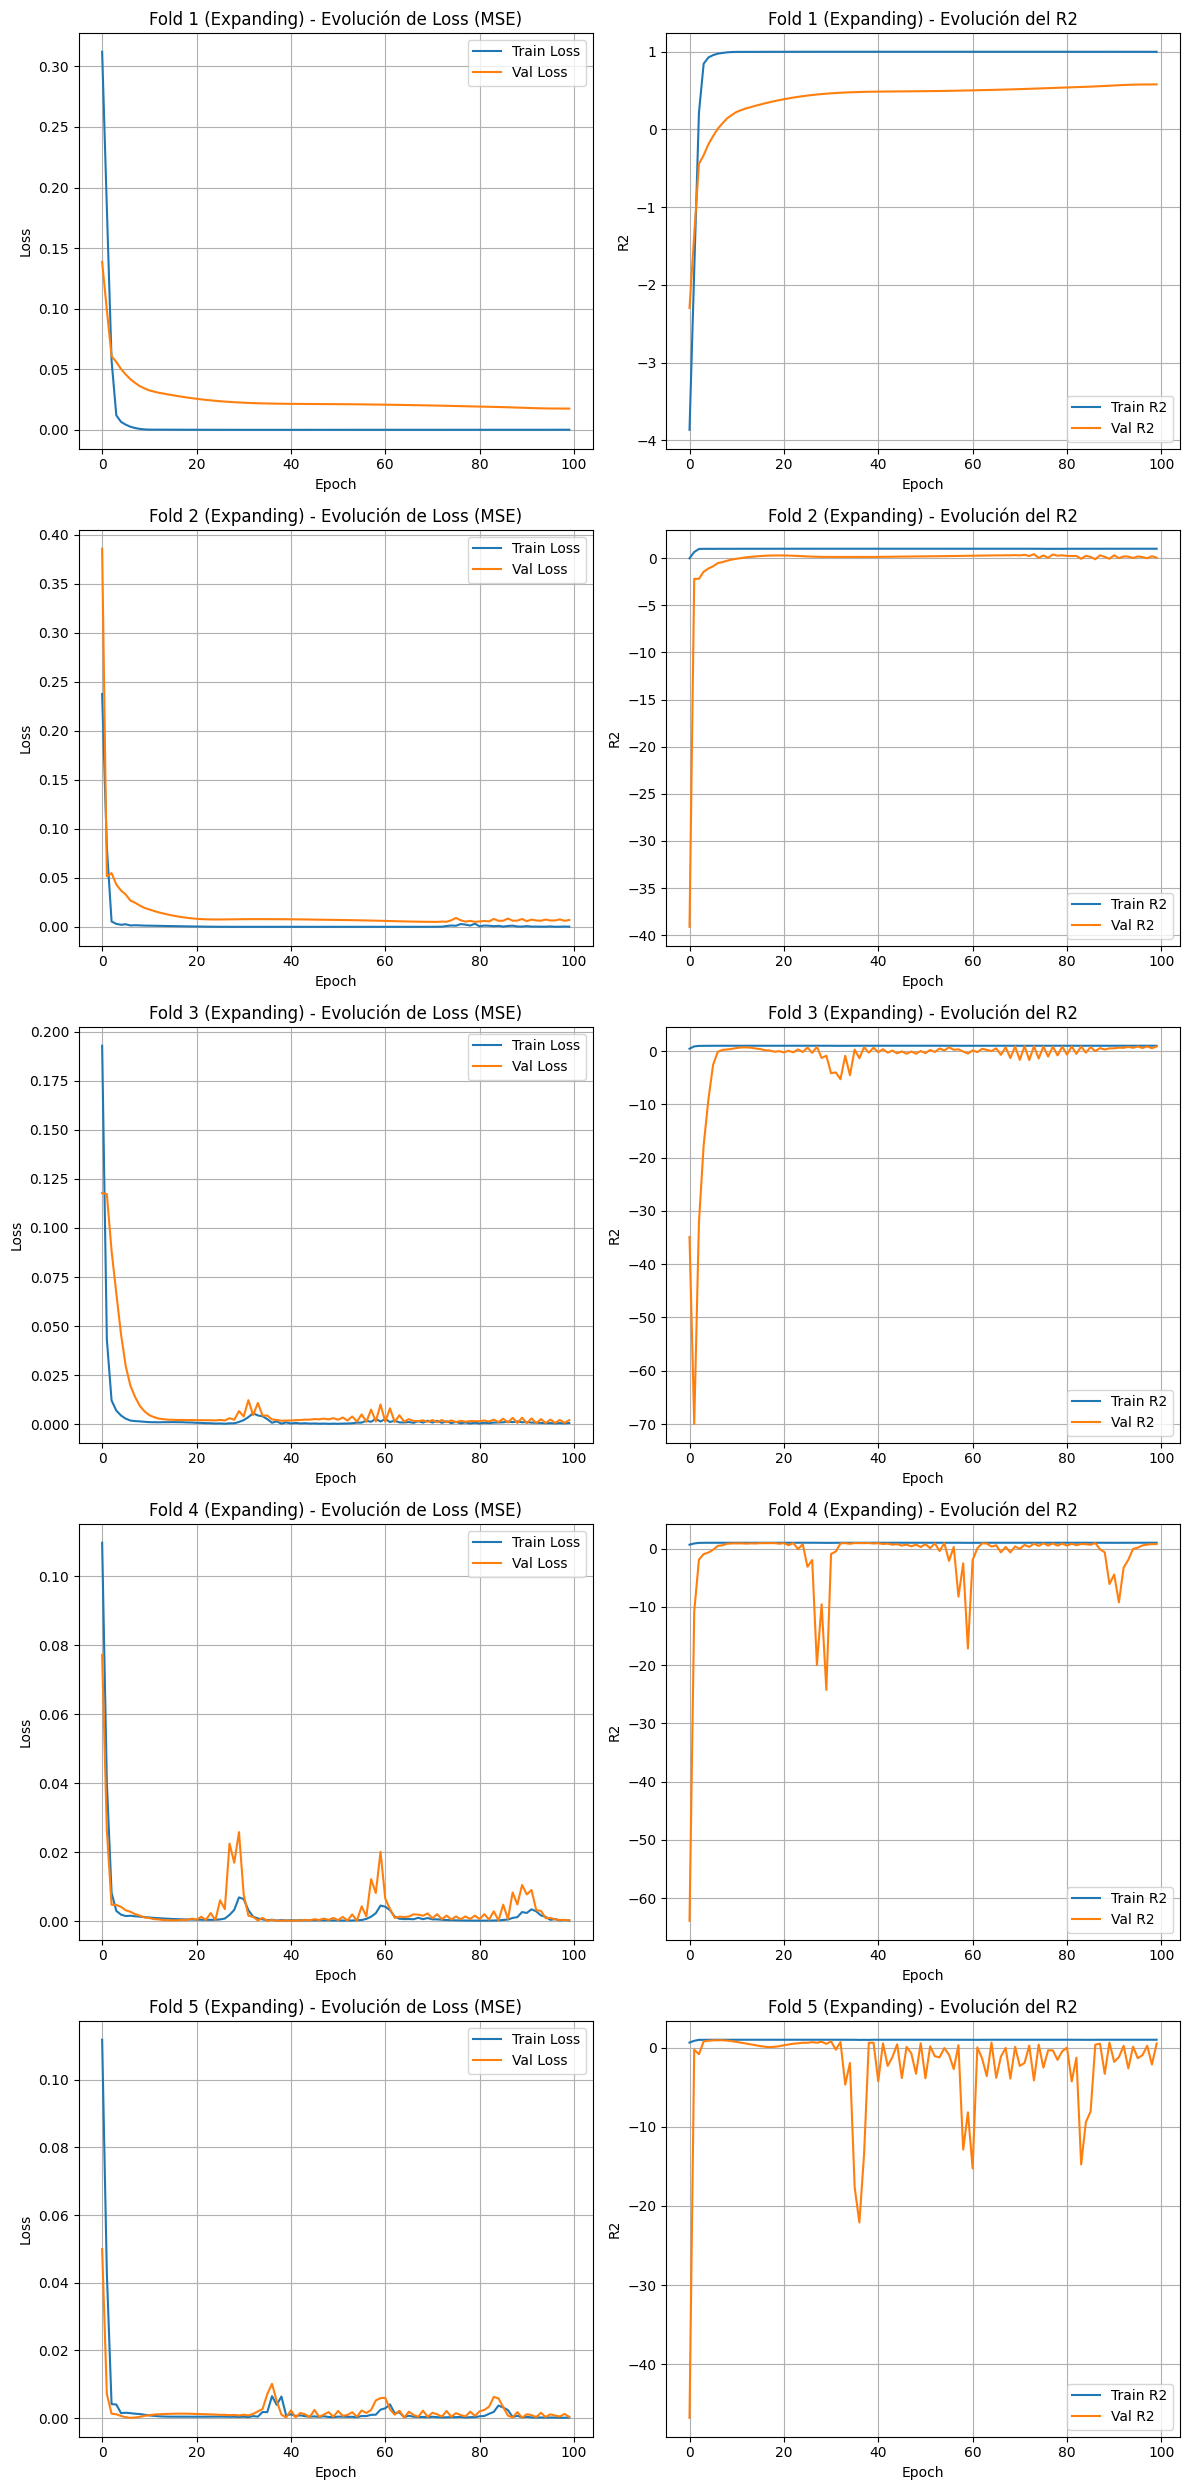

In [76]:
# --- After your training loop ---
fold_losses = [m['loss'] for m in fold_metrics_expanding]
fold_r2s   = [m['r2']   for m in fold_metrics_expanding]

mean_loss = np.mean(fold_losses)
mean_r2   = np.mean(fold_r2s)

print(f"Resultados CV (Expanding Window):")
for metrics in fold_metrics_expanding:
    print(f"  Fold {metrics['fold']}: Loss={metrics['loss']:.4f}, R2={metrics['r2']:.4f}")

print(f"\nPromedio final en CV:")
print(f"  Mean Loss = {mean_loss:.4f}")
print(f"  Mean R2   = {mean_r2:.4f}")

print(f"\nMejor fold (Expanding Window) fue el {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización de los cinco folds
fig, axes = plt.subplots(n_splits, 2, figsize=(12, 5 * n_splits))

for i in range(n_splits):
    history = fold_histories_expanding[i]
    ax1, ax2 = axes[i]

    ax1.plot(history['loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title(f'Fold {i + 1} (Expanding) - Evolución de Loss (MSE)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(history['r2_score'], label='Train R2')
    ax2.plot(history['val_r2_score'], label='Val R2')
    ax2.set_title(f'Fold {i + 1} (Expanding) - Evolución del R2')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('R2')
    ax2.grid(True)
    ax2.legend()

plt.tight_layout()
plt.show()

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2332 - r2_score: -42.4369
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0811 - r2_score: -8.1267
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0121 - r2_score: -0.1841
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0037 - r2_score: 0.1472
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0051 - r2_score: 0.0196 
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0035 - r2_score: 0.2079
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0018 - r2_score: 0.8299
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0040 - r2_score: 0.0744
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0027 - r2_score: 0.4047
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0021 - r2_score: 0.6286
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0024 - r2_score: 0.4426
Epoch 12/100
131/131 ━━━━

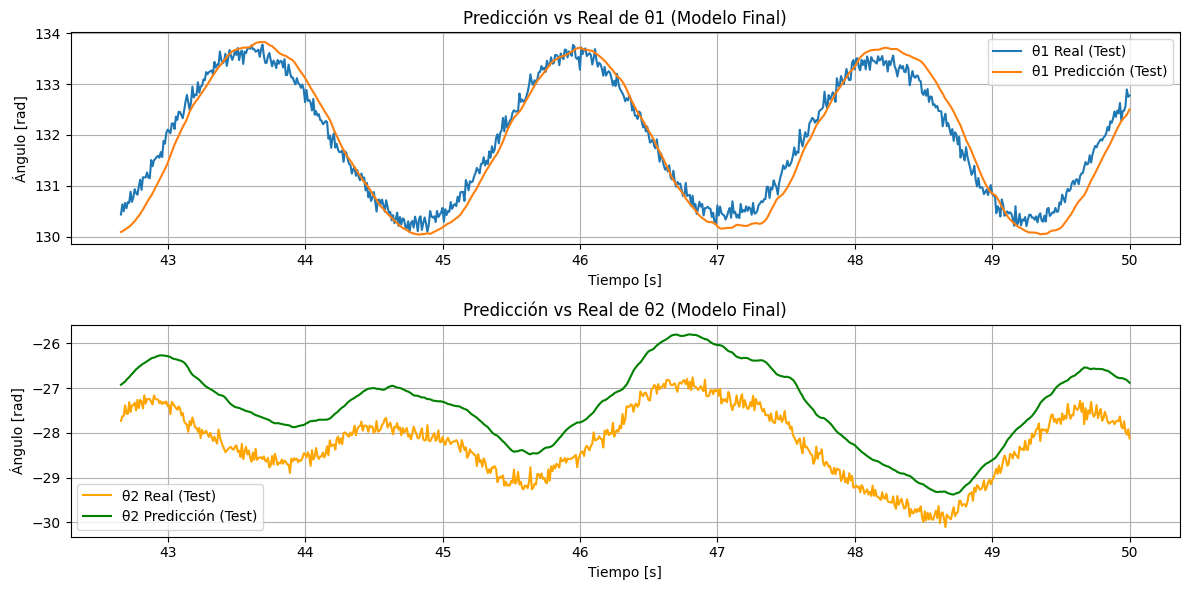

Métricas Globales en Test (Modelo Final con Train+Val):
MSE: 0.4150
MAE: 0.5398
R2:  0.3428


In [77]:
# --- Entrenar el modelo final con todo train + val ---
X_train_val = np.concatenate([X_train, X_val], axis=0)
Y_train_val = np.concatenate([Y_train, Y_val], axis=0)

# Definir el modelo final con la misma configuración (por ejemplo, LSTM(50) y Dense(2))
model_final = Sequential([
    LSTM(100, input_shape=(window_size, 2), return_sequences=True),
    # LSTM(50, return_sequences=True),
    LSTM(100, return_sequences=False),
    Dense(2)
])

model_final.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

# Entrenar el modelo final (puedes usar un pequeño validation_split para monitorear el proceso)
history_final = model_final.fit(
    X_train_val, Y_train_val,
    epochs=100,
    batch_size=32,
    # validation_split=0.1,
    shuffle=False,
    verbose=1
)

# --- Evaluar en el conjunto de test ---
Y_pred_test = model_final.predict(X_test)
Y_pred_test_inv = scaler_y.inverse_transform(Y_pred_test)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Definir el eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# --- Graficar la predicción vs. datos reales ---pp
plt.figure(figsize=(12, 6))

# Gráfica para θ1
plt.subplot(2, 1, 1)
plt.plot(t_test, Y_test_inv[:, 0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_inv[:, 0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Modelo Final)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# Gráfica para θ2
plt.subplot(2, 1, 2)
plt.plot(t_test, Y_test_inv[:, 1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_inv[:, 1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Modelo Final)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Calcular e imprimir métricas en Test ---
mse_final = mean_squared_error(Y_test_inv, Y_pred_test_inv)
mae_final = mean_absolute_error(Y_test_inv, Y_pred_test_inv)
r2_final  = r2_score(Y_test_inv, Y_pred_test_inv)

print("Métricas Globales en Test (Modelo Final con Train+Val):")
print(f"MSE: {mse_final:.4f}")
print(f"MAE: {mae_final:.4f}")
print(f"R2:  {r2_final:.4f}")


---

## 2 capas units=100, reduce_lr --> peor resultado



In [66]:
n_splits = 5
from sklearn.model_selection import TimeSeriesSplit
# TimeSeriesSplit con Expanding Window (sin max_train_size)
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

best_r2_expanding = -1e6
best_model_expanding = None
best_fold_expanding = None
fold_histories_expanding = []
fold_metrics_expanding = []

fold = 1
for train_index, val_index in tscv_expanding.split(X_train):
    print(f"Fold {fold} (Expanding)")
    X_train_exp, X_val_exp = X_train[train_index], X_train[val_index]
    Y_train_exp, Y_val_exp = Y_train[train_index], Y_train[val_index]

    # Definir modelo RNN (LSTM)
    model_exp = Sequential([
        LSTM(100, input_shape=(window_size, 2), return_sequences=True),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(2)
    ])

    model_exp.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7, verbose=1)

    # Entrenar
    history_exp = model_exp.fit(
        X_train_exp, Y_train_exp,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_exp, Y_val_exp),
        shuffle=False,
        callbacks=[reduce_lr],
        verbose=1
    )

    fold_histories_expanding.append(history_exp.history)

    loss_exp, r2_exp = model_exp.evaluate(X_val_exp, Y_val_exp, verbose=1)
    fold_metrics_expanding.append({'fold': fold, 'loss': loss_exp, 'r2': r2_exp})
    print(f"Fold {fold} (Expanding) - Loss: {loss_exp:.4f}, R2: {r2_exp:.4f}\n")

    if r2_exp > best_r2_expanding:
        best_r2_expanding = r2_exp
        best_model_expanding = model_exp
        best_fold_expanding = fold

    fold += 1





Fold 1 (Expanding)
Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.4475 - r2_score: -228.9525 - val_loss: 0.0970 - val_r2_score: -1.3053 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.2063 - r2_score: -108.8701 - val_loss: 0.0606 - val_r2_score: -0.4375 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0309 - r2_score: -14.3390 - val_loss: 0.0418 - val_r2_score: 0.0076 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0249 - r2_score: -14.2116 - val_loss: 0.0468 - val_r2_score: -0.1119 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0232 - r2_score: -8.7298 - val_loss: 0.0348 - val_r2_score: 0.1743 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0128 - r2_score: -5.5004 - val_loss: 0.0340 - val_r2_score: 0.1934 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0

Resultados CV (Expanding Window):
  Fold 1: Loss=0.0173, R2=0.5852
  Fold 2: Loss=0.0071, R2=0.2272
  Fold 3: Loss=0.0025, R2=0.1654
  Fold 4: Loss=0.0006, R2=0.6291
  Fold 5: Loss=0.0002, R2=0.9351

Promedio final en CV:
  Mean Loss = 0.0056
  Mean R2   = 0.5084

Mejor fold (Expanding Window) fue el 5 con R2=0.9351


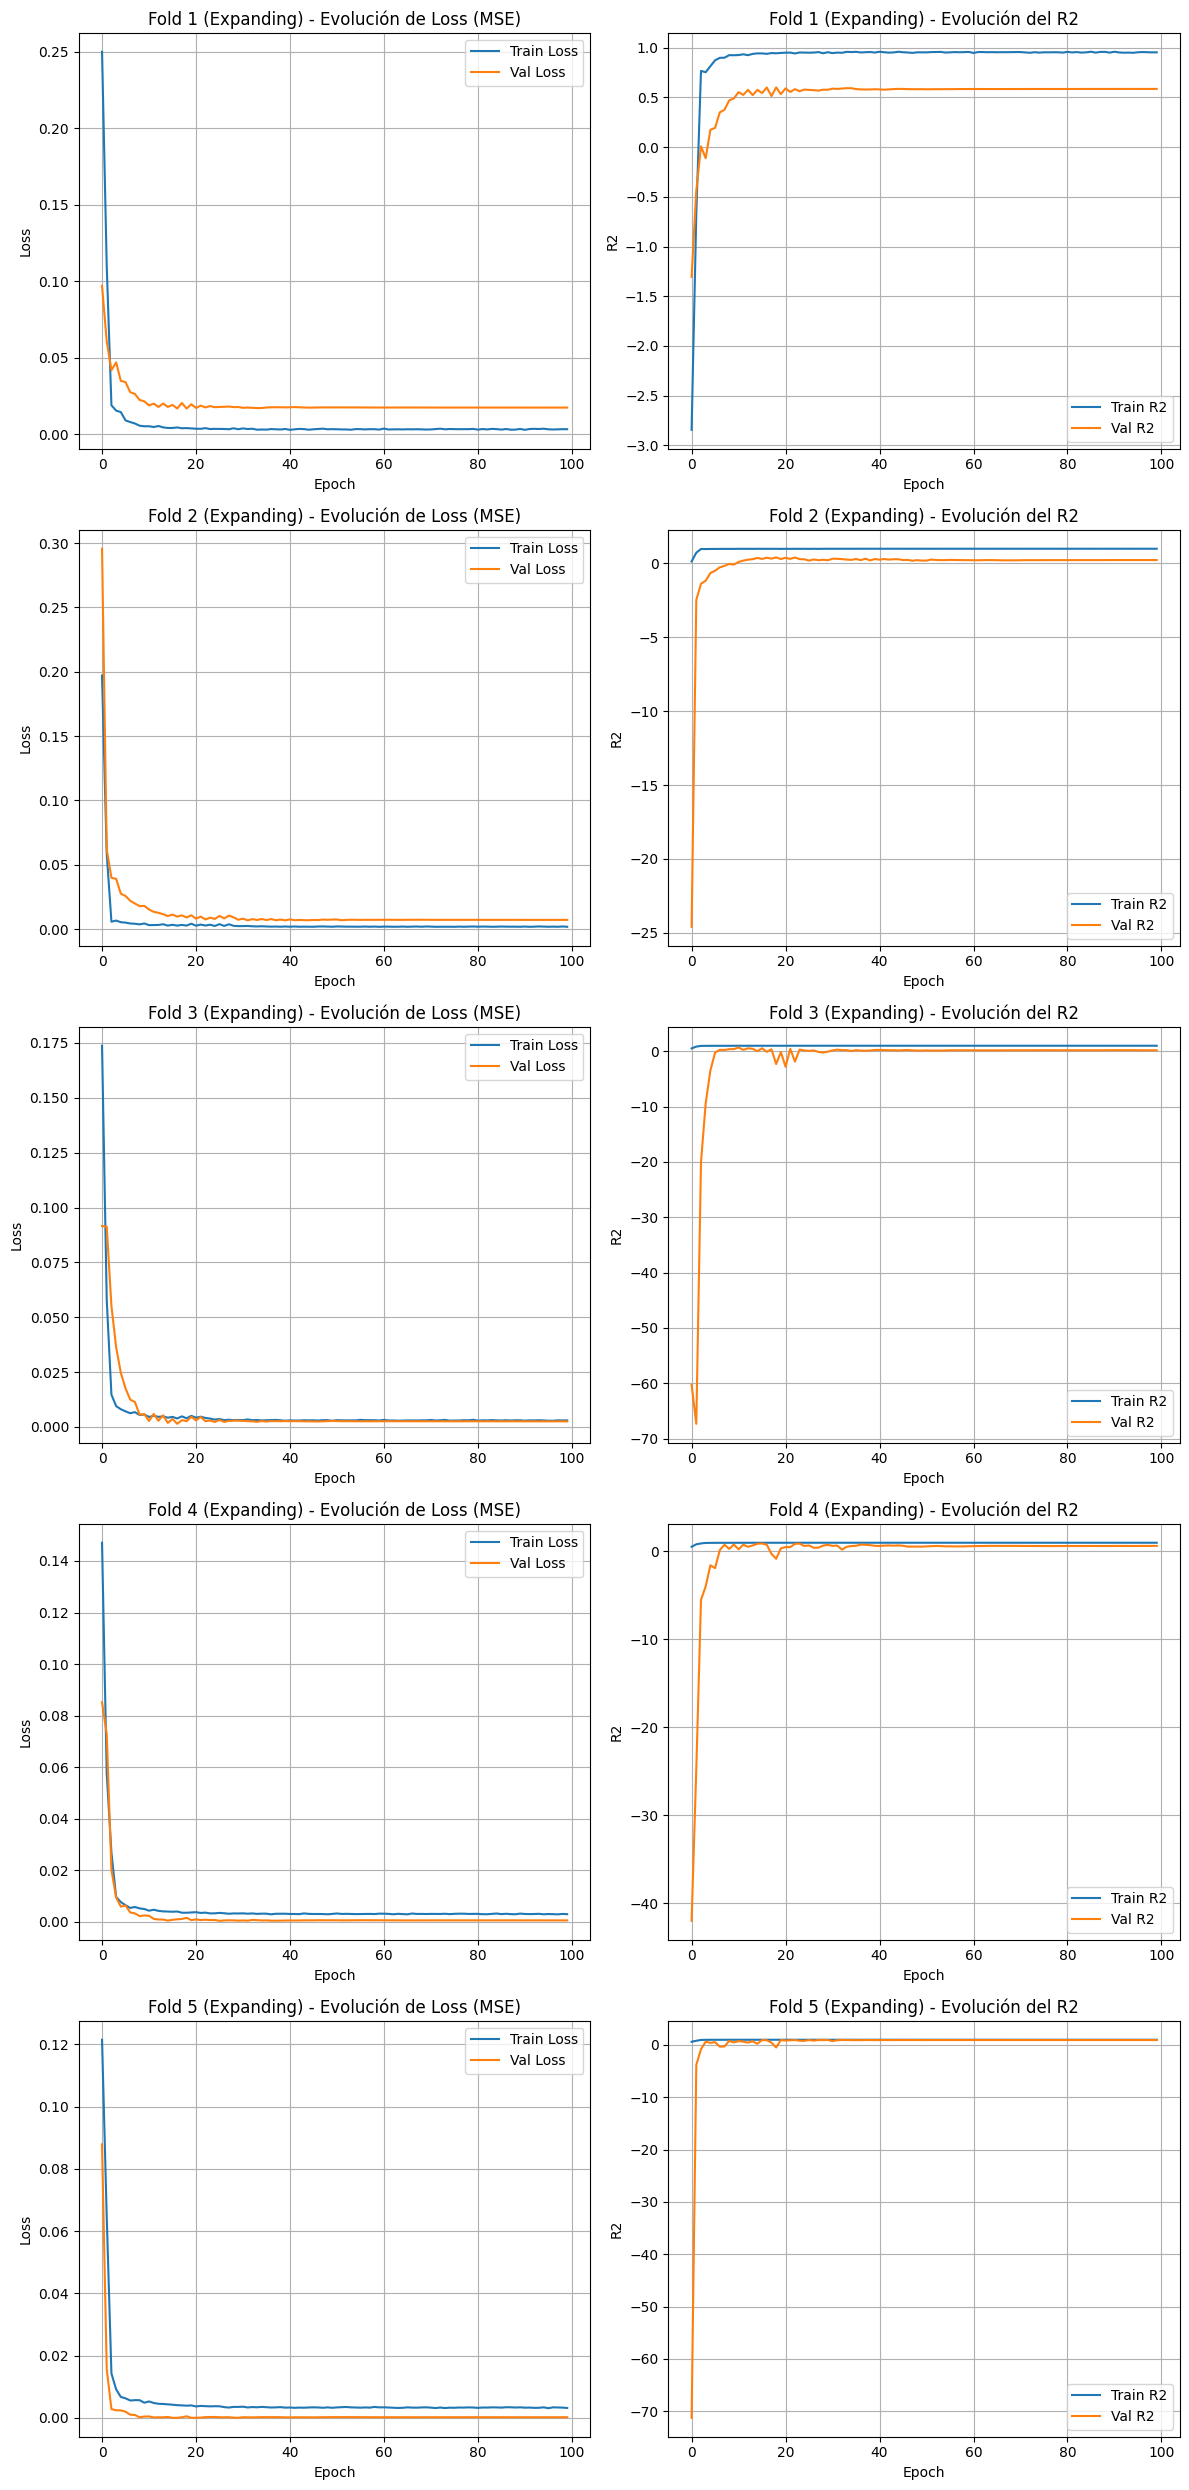

In [67]:
# --- After your training loop ---
fold_losses = [m['loss'] for m in fold_metrics_expanding]
fold_r2s   = [m['r2']   for m in fold_metrics_expanding]

mean_loss = np.mean(fold_losses)
mean_r2   = np.mean(fold_r2s)

print(f"Resultados CV (Expanding Window):")
for metrics in fold_metrics_expanding:
    print(f"  Fold {metrics['fold']}: Loss={metrics['loss']:.4f}, R2={metrics['r2']:.4f}")

print(f"\nPromedio final en CV:")
print(f"  Mean Loss = {mean_loss:.4f}")
print(f"  Mean R2   = {mean_r2:.4f}")

print(f"\nMejor fold (Expanding Window) fue el {best_fold_expanding} con R2={best_r2_expanding:.4f}")

# Visualización de los cinco folds
fig, axes = plt.subplots(n_splits, 2, figsize=(12, 5 * n_splits))

for i in range(n_splits):
    history = fold_histories_expanding[i]
    ax1, ax2 = axes[i]

    ax1.plot(history['loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title(f'Fold {i + 1} (Expanding) - Evolución de Loss (MSE)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(history['r2_score'], label='Train R2')
    ax2.plot(history['val_r2_score'], label='Val R2')
    ax2.set_title(f'Fold {i + 1} (Expanding) - Evolución del R2')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('R2')
    ax2.grid(True)
    ax2.legend()

plt.tight_layout()
plt.show()

# Visualización del mejor fold
best_history_exp = fold_histories_expanding[best_fold_expanding - 1]

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.1812 - r2_score: -39.1315 - learning_rate: 1.0000e-04
Epoch 2/100
  8/131 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5000 - r2_score: -449.2747

/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score,learning_rate.
  callback.on_epoch_end(epoch, logs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0910 - r2_score: -26.9691 - learning_rate: 1.0000e-04
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0137 - r2_score: -1.3649 - learning_rate: 1.0000e-04
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0122 - r2_score: -3.2481 - learning_rate: 1.0000e-04
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0132 - r2_score: -1.2773 - learning_rate: 1.0000e-04
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0078 - r2_score: -0.7891 - learning_rate: 1.0000e-04
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0078 - r2_score: -1.1215 - learning_rate: 1.0000e-04
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0114 - r2_score: -1.4857 - learning_rate: 1.0000e-04
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0035 - r2_score: 0.8342 - learning_rate: 1.0000e-04
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0159 - r2_s

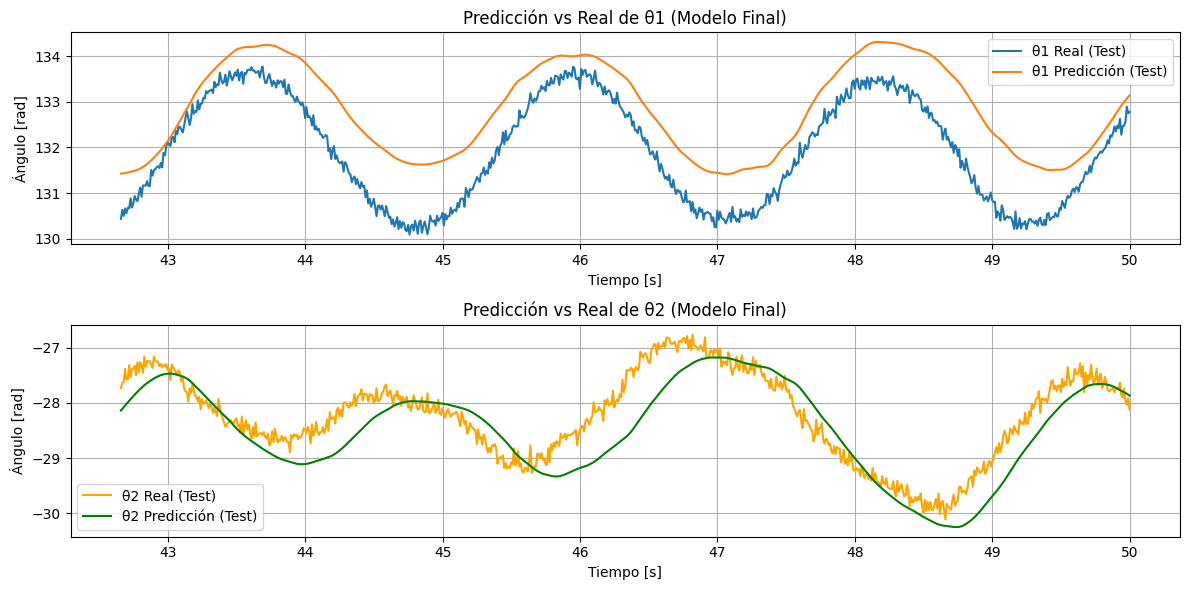

Métricas Globales en Test (Modelo Final con Train+Val):
MSE: 0.5722
MAE: 0.6300
R2:  0.4666


In [74]:
# --- Entrenar el modelo final con todo train + val ---
X_train_val = np.concatenate([X_train, X_val], axis=0)
Y_train_val = np.concatenate([Y_train, Y_val], axis=0)

# Definir el modelo final con la misma configuración (por ejemplo, LSTM(50) y Dense(2))
model_final = Sequential([
    LSTM(100, input_shape=(window_size, 2), return_sequences=True),
    LSTM(100, return_sequences=True),
    LSTM(100, return_sequences=True),
    LSTM(100, return_sequences=False),
    Dense(2)
])

model_final.compile(loss='mean_squared_error', optimizer=Adam(1e-4), metrics=['r2_score'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7, verbose=1)

# Entrenar el modelo final (puedes usar un pequeño validation_split para monitorear el proceso)
history_final = model_final.fit(
    X_train_val, Y_train_val,
    epochs=100,
    batch_size=32,
    # validation_split=0.1,
    shuffle=False,
    callbacks=[reduce_lr],
    verbose=1
)

# --- Evaluar en el conjunto de test ---
Y_pred_test = model_final.predict(X_test)
Y_pred_test_inv = scaler_y.inverse_transform(Y_pred_test)
Y_test_inv = scaler_y.inverse_transform(Y_test)

# Definir el eje de tiempo para test
test_index_start = (train_size + val_size) + window_size
t_test = t_eval[test_index_start:]

# --- Graficar la predicción vs. datos reales ---
plt.figure(figsize=(12, 6))

# Gráfica para θ1
plt.subplot(2, 1, 1)
plt.plot(t_test, Y_test_inv[:, 0], label='θ1 Real (Test)')
plt.plot(t_test, Y_pred_test_inv[:, 0], label='θ1 Predicción (Test)')
plt.title('Predicción vs Real de θ1 (Modelo Final)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

# Gráfica para θ2
plt.subplot(2, 1, 2)
plt.plot(t_test, Y_test_inv[:, 1], label='θ2 Real (Test)', color='orange')
plt.plot(t_test, Y_pred_test_inv[:, 1], label='θ2 Predicción (Test)', color='green')
plt.title('Predicción vs Real de θ2 (Modelo Final)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Calcular e imprimir métricas en Test ---
mse_final = mean_squared_error(Y_test_inv, Y_pred_test_inv)
mae_final = mean_absolute_error(Y_test_inv, Y_pred_test_inv)
r2_final  = r2_score(Y_test_inv, Y_pred_test_inv)

print("Métricas Globales en Test (Modelo Final con Train+Val):")
print(f"MSE: {mse_final:.4f}")
print(f"MAE: {mae_final:.4f}")
print(f"R2:  {r2_final:.4f}")
